# Wrangle Exercise

- [Zillow](#zillow)
- [Mall Customers](#Mall-Customers)

## Zillow

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import env

pd.options.display.max_rows = 100

import wrangle_zillow

df = wrangle_zillow.acquire()

/var/folders/5m/hv7mb0z95vnfhz0xb0s_rxym0000gn/T/ipykernel_76055/3877515818.py:17: DtypeWarning: Columns (63) have mixed types.Specify dtype option on import or set low_memory=False.
  df = wrangle_zillow.acquire()


In [2]:
wrangle_zillow.overview(df)

--- Shape: (77380, 68)
--- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77380 entries, 0 to 77379
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77380 non-null  int64  
 1   parcelid                      77380 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77380 non-null  float64
 6   bedroomcnt                    77380 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49671 non-null  float64
 9   calculatedbathnbr             76771 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6023 non-null   float64
 12  calculatedfinishedsquarefeet

In [3]:
wrangle_zillow.nulls_by_columns(df).sort_values(by='percent')

,count,percent
id,0,0.000000
propertylandusedesc,0,0.000000
transactiondate,0,0.000000
logerror,0,0.000000
assessmentyear,0,0.000000
roomcnt,0,0.000000
regionidcounty,0,0.000000
rawcensustractandblock,0,0.000000
propertylandusetypeid,0,0.000000
longitude,0,0.000000


In [4]:
wrangle_zillow.nulls_by_rows(df)

n_missing  percent_missing
23         0.338235               2
24         0.352941              13
25         0.367647              24
26         0.382353              65
27         0.397059             316
28         0.411765             455
29         0.426471            5270
30         0.441176            3455
31         0.455882            9891
32         0.470588           12579
33         0.485294           14782
34         0.500000           13326
35         0.514706            5148
36         0.529412            5775
37         0.544118            3620
38         0.558824            1925
39         0.573529             285
40         0.588235             230
41         0.602941              29
42         0.617647              23
43         0.632353              28
44         0.647059              78
45         0.661765              50
46         0.676471               5
47         0.691176               3
48         0.705882               3
dtype: int64

In [5]:
print('Before dropping nulls, %d rows, %d cols' % df.shape)
df = wrangle_zillow.handle_missing_values(df, prop_required_column=.5, prop_required_row=.5)
print('After dropping nulls, %d rows, %d cols' % df.shape)

Before dropping nulls, 77380 rows, 68 cols
After dropping nulls, 60178 rows, 34 cols


What do do with the rest of the nulls?

Start by dropping all nulls; that's the easiest thing to do in order to get to an MVP.

For a second pass, consider adding a handful of columns at a time and investigating nulls in those columns. Prioritize which columns to investigate based on the percentage of missing values and/or what we think might be most useful.

## Mall Customers

In [8]:
import wrangle_mall

df = wrangle_mall.get_exploration_data()

Train: 136 rows, 5 cols
Validate: 34 rows, 5 cols
Test: 30 rows, 5 cols


In [10]:
df.shape

(136, 5)

In [13]:
train, validate, test = wrangle_mall.get_modeling_data(scale_data=True)

Train: 136 rows, 5 cols
Validate: 34 rows, 5 cols
Test: 30 rows, 5 cols


In [14]:
train.head()

,customer_id,age,annual_income,spending_score,is_female
32,33,0.673077,0.147541,0.030612,False
186,187,0.692308,0.704918,0.234694,True
77,78,0.423077,0.319672,0.479592,False
33,34,0.000000,0.147541,0.928571,False
58,59,0.173077,0.254098,0.510204,True


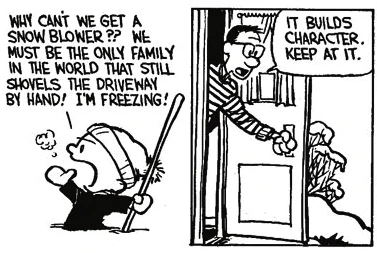